## Accessing and working with a dataset

### Access to the directory in the file system

The datasets selected for working are mounted in `/home/chameleon/datasets/` or simply `~/datasets/`.

In [1]:
import os
datasets_dir_path = "/home/chaimeleon/datasets"
datasets = os.listdir(datasets_dir_path)
datasets

['a092a929-ef5b-41f2-93ee-9231c56beeb6']

This is the ID of the dataset we have selected for this example.  
Let's see the contents...

In [25]:
dataset = datasets[0]
dataset_dir_path = os.path.join(datasets_dir_path, dataset)
print(dataset_dir_path)
contents = os.listdir(dataset_dir_path)
print(contents[0:5])

/home/chaimeleon/datasets/a092a929-ef5b-41f2-93ee-9231c56beeb6
['c3afa0c4942293e9e69ad2438cdd30d87551dccc652c58a8520a1f94b1f5cf01', '68159032c636bef4b2e222b2dfee6c415d59dc4e78ad9b0864d4a9edab4dffce', 'e7b7e879c2378ac91c8ac78e5e7915bf0ccae13d4035afc423049dfbd8a973e9', 'cc5109d7695977603d637de7b8c724c60fba0c0ef0fb71a1f06506103eb9121c', '5048349d66d6cc690122e7e52f202ba68c0efdaeb86538dad3c95a707f6b55d1']


Those are the first five entries which are directories of subjects, but the dataset directory not only contains subject directories, it also contains the files `index.json` and `eforms.json`.

### Reading `index.json` file

It is the entry point for accessing the contents of a dataset. It contains a list of the studies composing the dataset. Here is the JSON schema:  
https://github.com/chaimeleon-eu/dataset-service/blob/main/index.schema.json

Let's read and parse as JSON...

In [26]:
import json
index_file_path = os.path.join(dataset_dir_path, "index.json")
with open(index_file_path) as f:
    studies = json.load(f)

Now we can see the properties of (for example) the third study of the dataset simply with:

In [27]:
studies[2]

{'studyId': '65134d4068c17e0001d0777e',
 'studyName': 'RM PRÓSTATA MULTIPARAMÉTRICA',
 'subjectName': '21b51dc175b78ad73fac9a4273495227bb4982596f891983ce49a8b7936eaeba',
 'url': 'https://chaimeleon-eu.i3m.upv.es/omni/#/<USER>/study/65134d4068c17e0001d0777e/serie/65134d4068c17e0001d0777b',
 'series': [{'folderName': '12826013680043104361418283069478287525148582927215444053',
   'tags': []},
  {'folderName': '12826013680043104369529636949012539641117135696860107575',
   'tags': []},
  {'folderName': '12826013680043104364607562498981414384020565598718577274',
   'tags': []},
  {'folderName': '12826013680043104363336861412294865993213455914417085475',
   'tags': []},
  {'folderName': '12826013680043104365563727603040339210181814665043855304',
   'tags': []},
  {'folderName': '12826013680043104368403072354952532570949359077724731883',
   'tags': []},
  {'folderName': '12826013680043104368144584059056245242652662279748204772',
   'tags': []},
  {'folderName': '1282601368004310436954404704323

If we want to access the DICOM files, we must concatenate the `path` of the study and the `folderName` of the selected series. Let's see the contents of the third series:

In [37]:
study = studies[2]
series = study["series"][1]
serie_dir_path = os.path.join(dataset_dir_path, study["path"], series["folderName"])
images = [file for file in os.listdir(serie_dir_path) if file.endswith(".dcm")]
print(f"{len(images)} images in that series")
print(images[0:3])

24 images in that series
['1.2.826.0.1.3680043.10.436.8968871597206806076219595887562595913.dcm', '1.2.826.0.1.3680043.10.436.2926252302677232476252229816064425671.dcm', '1.2.826.0.1.3680043.10.436.6466148474788117857947837755736184547.dcm']


And finally we can see one of the images with:

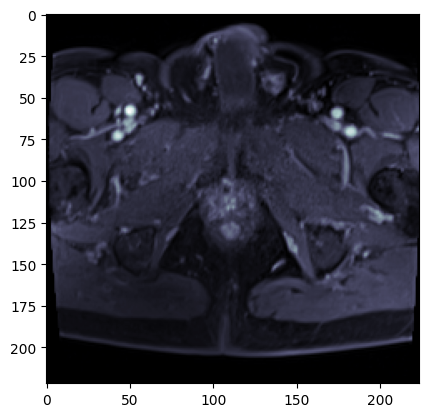

In [38]:
import matplotlib.pyplot as plt
import pydicom
dcm_file_path = os.path.join(serie_dir_path, images[3])
ds = pydicom.dcmread(dcm_file_path)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

Also the DICOM tags...

In [39]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.436.1054505405026003655585315668088325380
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.3
(0002, 0013) Implementation Version Name         SH: 'dcm4che-5.29.2'
(0002, 0016) Source Application Entity Title     AE: 'DCM4CHEE'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS2D', 'MFSPLIT']
(0008, 0012) Instance Creation Date              DA: '20221018'
(0008, 0013) Instance Creation Time              TM: '111344.120310'

### Reading the file `eforms.json`

That file contains all the clinical data for each subject of study.  
Here is the JSON schema:
https://github.com/chaimeleon-eu/dataset-service/blob/main/eforms.schema.json  

We have previously seen there is a property `subjectName` for each study in the `index.json` file, 
so here in the `eforms.json` file there is a list of subjects with: 
 - that same property `subjectName` (you should use it as a reference key to relate with the studies in index)
 - and the `eForm` property which contains all the clinical data.

Let's read and parse as JSON...

In [40]:
import json
eforms_file_path = os.path.join(dataset_dir_path, "eforms.json")
with open(eforms_file_path) as f:
    subjectsList = json.load(f)

We convert to a dictionary to easily find subjects:

In [41]:
subjects = dict([ (subject["subjectName"], subject["eForm"]) for subject in subjectsList ])

And now let's see the clinical data of the subject of the previous study:

In [42]:
print(study["subjectName"])
subject = subjects[study["subjectName"]]
# print the first 800 chars
print(str(subject)[:800])

21b51dc175b78ad73fac9a4273495227bb4982596f891983ce49a8b7936eaeba
{'metaproject': 'ChAImeleon Prostate', 'chaimeleon_patient_id': '21b51dc175b78ad73fac9a4273495227bb4982596f891983ce49a8b7936eaeba', 'pages': [{'page_name': 'inclusion_criteria', 'page_label': 'Inclusion criteria', 'page_data': {'baseline_date': {'var_label': 'Date of imaging baseline (calculated)*', 'value': '2018-01-01', 'value_type': 'datepicker'}, 'age_at_diagnosis': {'var_label': 'Age at baseline (calculated)', 'value': 74, 'value_type': 'integer'}, 'difference_diagnosis_treatment': {'var_label': 'Difference between date of pathology sample and first treatment in months (calculated)', 'value': 5, 'value_type': 'integer'}, 'no_personal_history_cancer': {'var_label': "The patient doesn't have previous history of other cancer", 'value': True, 'value_type': 'boolean'}}, 'lists': []}, {'pag


So in that case we can get the age with:

In [43]:
for page in subject["pages"]:
    if page["page_name"] == "inclusion_criteria":
        print(page["page_data"]["age_at_diagnosis"]["value"])

74


## APPLICATION EXECUTION

Now we are going to execute an example of application which scans a dataset and filters it taking out only the studies and series with a selected orientation.

If we execute the application without arguments, we will see an error and which arguments are required.

In [44]:
!python3 ~/persistent-shared-folder/APPLICATION-EXAMPLES/filter-series-by-orientation.py

Error: three arguments are required. 
       - The first is the input, the directory path of the dataset to filter,
         that directory should contain an index.json file.
       - The second is the filter: X_TRANSVERSE, Y_CORONAL or Z_SAGITTAL.
       - The third is the output file path where the filtered index will be written,
         only the studies and series with the orientation selected will be included.

Usage example: 
   python3 /home/chaimeleon/persistent-shared-folder/APPLICATION-EXAMPLES/filter-series-by-orientation.py datasets/e52faf1b-ecc2-4a96-957d-c8b4e34d607a Y_CORONAL persistent-home/e52faf1b-coronal-index.json



So, let's filter our dataset. We want to take out for example the sagittal series.

In [45]:
!python3 ~/persistent-shared-folder/APPLICATION-EXAMPLES/filter-series-by-orientation.py \
         ~/datasets/a092a929-ef5b-41f2-93ee-9231c56beeb6 \
         Z_SAGITTAL \
         ~/persistent-home/index-prostate-sagittal.json

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
# Input studies: 736
##### Input series #####
# X_TRANSVERSE:     1310
# Y_CORONAL:        2668
# Z_SAGITTAL:      11044
# UNDEFINED:           0
########################
# Output studies: 736
# Output series: 11044

Writing filtered INDEX: /home/chaimeleon/persi

### Launching with _jobman_

When you need to execute some application that require more computational resources, specially for using GPU, you must launch the job with _jobman_. You can use the command `jobman` without arguments just to see some examples of usage or `jobman --help` to see in detail all you can do with it.

When launching a job we can select an image, let's see the list of currently available images...

In [46]:
!jobman images

Getting repos from https://harbor.chaimeleon-eu.i3m.upv.es:5000/api/v2.0/projects/chaimeleon-library-batch/repositories
┌──────────────────────────┬──────────────────────────────────────────────────┐
│ Image Name               │ Tags List                                        │
├──────────────────────────┼──────────────────────────────────────────────────┤
│ shap-exp-tool            │ 0.0.3-testing  latest                            │
│ ubuntu-python-pytorch    │ latest-cuda  3.7cuda11  latest  3.7  3.6cuda11   │
│                          │ 3.6                                              │
│ ubuntu-python-tensorflow │ latest  3.8  latest-cuda  3.8cuda11  3.7cuda11   │
│                          │ 3.7  3.6cuda11  3.6                              │
│ ubuntu-python            │ latest-cuda  3.7cuda11  latest  3.7  3.6cuda11   │
│                          │ 3.6  3.5cuda11  3.5                              │
│ mri_harmonization        │ 1.24  1.23  latest-cuda  1.18cuda  1.18-gpu      │


For this simple example we are going to use the most basic image `ubuntu-python` (indeed it is the default image if we don't set the argument `-i`).

And for submitting the job just write down the image name after `-i` and put the same command that you would execute in local after the "--" (in that case "python3 ...", the same command executed in the previous chapter):

In [47]:
!jobman submit -i ubuntu-python -- \
    python3 ~/persistent-shared-folder/APPLICATION-EXAMPLES/filter-series-by-orientation.py \
            ~/datasets/a092a929-ef5b-41f2-93ee-9231c56beeb6 \
            Z_SAGITTAL \
            ~/persistent-home/index-prostate-sagittal.json

Using image 'harbor.chaimeleon-eu.i3m.upv.es:5000/chaimeleon-library-batch/ubuntu-python'
 [SUCCESS]  Job named 'jobman-438f0dc4-93ba-442b-8a56-e30190dee3a8' created successfully by user 'inClusterUser'


Now the job is created and we can see the status...

In [49]:
!jobman list

┌─────────────────────────────────────────────┬───────────┬───────────┬────────────────┐
│ Job Name                                    │  Flavor   │  Status   │  Launch Date   │
├─────────────────────────────────────────────┼───────────┼───────────┼────────────────┤
│ jobman-438f0dc4-93ba-442b-8a56-e30190dee3a8 │  no-gpu   │  Running  │  06/05/2024,   │
│                                             │           │           │  10:55:58 UTC  │
│ jobman-cb35c67a-aec4-4980-99e6-00a6ee044f6b │  no-gpu   │ Succeeded │  07/11/2023,   │
│                                             │           │           │  16:44:05 UTC  │
│ jobman-4228bf42-e750-419e-9b44-6188dcc460ca │ small-gpu │ Succeeded │  18/10/2023,   │
│                                             │           │           │  18:59:20 UTC  │
│ jobman-d822028e-a155-451c-b7f0-104533d24129 │ large-gpu │ Succeeded │  16/10/2023,   │
│                                             │           │           │  15:58:22 UTC  │
│ job-48d64297-7f39-4

The job will be enqueued and, depending on the current demand in the cluster and the resources we require (if we require a GPU for example or not), the job will finish sooner or later with status "Succeeded" or "Failed".  

When finished o even still running, we can see the output with:

In [53]:
!jobman logs -j jobman-438f0dc4-93ba-442b-8a56-e30190dee3a8

Getting log for pod 'jobman-438f0dc4-93ba-442b-8a56-e30190dee3a8-wk7qk', user 'inClusterUser' in namespace 'user-testdatascientist'
----Log begin----

  ### Executing the user custom init script ###
### End of user custom init script ###
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
# Input studies: 736
####

Now, if you want to know how to submit a job with specific resources (like GPU) please go to the jobman section of the usage guide:  
https://github.com/chaimeleon-eu/workstation-images/blob/main/usage-guide.md#jobman-client-tool